In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

In [46]:
class MNISTAutoEncoder(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28)
        )
    
    def forward(self, x):
        return self.encoder(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [47]:
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])
BATCH_SIZE = 128

model = MNISTAutoEncoder(lr=1e-3)
trainer = pl.Trainer(max_epochs=100, gpus=1)
history = trainer.fit(model, 
            DataLoader(train, batch_size=BATCH_SIZE, num_workers=12), 
            DataLoader(val, batch_size=BATCH_SIZE, num_workers=12))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 109 K 
1 | decoder | Sequential | 110 K 
---------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params


Epoch 99: 100%|██████████| 430/430 [00:02<00:00, 159.28it/s, loss=0.0148, v_num=6]


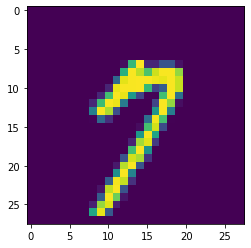

In [48]:
import matplotlib.pyplot as plt
import numpy as np
test = np.random.randint(low=0, high=60000)
plt.imshow(dataset[test][0][0].numpy())

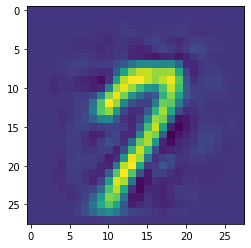

In [49]:
plt.imshow(model.decoder(model.encoder(torch.flatten(dataset[test][0]))).detach().numpy().reshape(28, 28))

In [51]:
history

1